# Multiarm badit sampling methods for exploration-exploitation tradeoff visualisation

### Legacy repo does not work with gymnasium so some installs and hacks are needed

In [2]:
#!pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk

In [1]:
#!pip install gym_walk
#!pip install gymnasium

In [1]:
#import numpy as np
#import gymnasium as gym, gym_walk
#import gymnasium as gym
#from gym_walk.envs import WalkEnv

In [2]:
#from gymnasium.envs.registration import register

In [3]:
#register(
#    # One non-terminal states and two terminal
#    # Technically speaking, this is a bandit MDP
#    id='BanditWalk-v0',
#    entry_point='gym_walk.envs:WalkEnv',
#    # left-most and right-most states are terminal
#    kwargs={'n_states': 1, 'p_stay': 0.0, 'p_backward': 0.0},
#    max_episode_steps=100,
#    reward_threshold=1.0,
#    nondeterministic=True,
#)

In [4]:
#register(
#    # One non-terminal states and two terminal
#    # Technically speaking, this is a bandit MDP
#    id='BanditSlipperyWalk-v0',
#    entry_point='gym_walk.envs:WalkEnv',
#    # left-most and right-most states are terminal
#    kwargs={'n_states': 1, 'p_stay': 0.0, 'p_backward': 0.2},
#    max_episode_steps=100,
#    reward_threshold=1.0,
#    nondeterministic=True,
#)

In [5]:
## (Stochastic) Markov Decission Problem: MDP
## s a (p(a|s), s', r, Teminal?)
#P = {
#    0: {
#        0: [(1.0, 0, 0.0, True)],
#        1: [(1.0, 0, 0.0, True)]
#    },
#    1: {
#        0: [(0.8, 0, 0.0, True), (0.2, 2, 1.0, True)],
#        1: [(0.8, 2, 1.0, True), (0.2, 0, 0.0, True)]
#    },
#    2: {
#        0: [(1.0, 2, 0.0, True)],
#        1: [(1.0, 2, 0.0, True)]
#    }
#}

In [6]:
#env = gym.make('BanditWalk-v0')

# Environment setup

### Upon installing gym_walk lib one can actuall directly instantiated envs used in the book by using proper env parameters

In [2]:
import numpy as np
from gym_walk.envs import WalkEnv

from tqdm import tqdm
import matplotlib.pyplot as plt

### Slippery walk 1D AKA two-arm stochastic bandid

In [3]:
env = WalkEnv(n_states=1, p_stay=0.0, p_backward=0.2)

In [4]:
env.P

{0: {0: [(0.8, 0, 0.0, True), (0.0, 0, 0.0, True), (0.2, 1, 0.0, False)],
  1: [(0.8, 1, 0.0, False), (0.0, 0, 0.0, True), (0.2, 0, 0.0, True)]},
 1: {0: [(0.8, 0, 0.0, True), (0.0, 1, 0.0, False), (0.2, 2, 1.0, True)],
  1: [(0.8, 2, 1.0, True), (0.0, 1, 0.0, False), (0.2, 0, 0.0, True)]},
 2: {0: [(0.8, 1, 0.0, False), (0.0, 2, 0.0, True), (0.2, 2, 0.0, True)],
  1: [(0.8, 2, 0.0, True), (0.0, 2, 0.0, True), (0.2, 1, 0.0, False)]}}

In [5]:
env.reset()

(1, {'prob': 1.0})

In [6]:
env.step(1)

(2, 1.0, True, False, {'prob': 0.8, 'success': True})

## Policy Evaluation - Q value in one state env of multiarm bandit: proxy to Q values of RL with states and multiple actions

In [7]:
env.action_space

Discrete(2)

In [8]:
env.action_space.n

2

### Exploration-exploitation strategies for Q-value estimation

### Pure Exploitation

In [1]:
def pure_exploitation(env, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype = int)

    name = 'Pure exploitation'

    for e in tqdm(range(n_episodes), desc='Episodes for: ' + name):#, leave=False):
        action = np.argmax(Q)
        _, reward, _, _, _= env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

    return name, returns, Qe, actions

### Pure Exploration

In [24]:
def pure_exploration(env, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype = int)

    name = 'Pure exploration'

    for e in tqdm(range(n_episodes), desc='Episodes for: ' + name):#, leave=False):
        action = np.random.randint(len(Q))
        _, reward, _, _, _= env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

    return name, returns, Qe, actions

### Softmax Exploration

In [18]:
def softmax_exploration(env,
                       init_temp=1000.0,
                       min_temp=0.01,
                       decay_ratio=0.2,
                       n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype = int)

    name = 'Softmax exploration'

    for e in tqdm(range(n_episodes), desc='Episodes for: ' + name):#, leave=False):
        
        decay_episodes = n_episodes * decay_ratio
        temp = 1 - e /decay_episodes
        temp *= init_temp - min_temp
        temp += min_temp
        temp = np.clip(temp, min_temp, init_temp)

        scaled_Q = Q / temp
        norm_Q = scaled_Q - np.max(scaled_Q)
        exp_Q = np.exp(scaled_Q)
        probs = exp_Q / np.sum(exp_Q)
        
        assert np.isclose(probs.sum(), 1.0)
        
        action = np.random.choice(np.arange(len(probs)),
                                  size=1,
                                  p=probs)[0]
        
        _, reward, _, _, _= env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

    return name, returns, Qe, actions

### Thompson Sampling (with Upper Conficende Bound version comment)

In [4]:
def thompson_sampling(env,
                      alpha=1,
                      beta=0,
                      n_episodes=5000):
 
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype = int)

    name = 'Thompson sampling'

    for e in tqdm(range(n_episodes), desc='Episodes for: ' + name):#, leave=False):

        # For UCB sampling:
        # U = c * np.sqrt(np.log(e) / N)
        # samples = Q + U
        samples = np.random.normal(loc=Q,
                                   scale=alpha/(np.sqrt(N) + beta))
        action = np.argmax(samples)
                                 
        _, reward, _, _, _= env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

    return name, returns, Qe, actions

### Env step examples

In [11]:
env.step(1)

(1, 0.0, False, False, {'prob': 0.8, 'success': False})

## Results - Q values of both actions

In [12]:
ret = pure_exploitation(env)

Episodes for: Pure exploitation: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 45636.39it/s]


In [15]:
ret

('Pure exploitation',
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([[1.        , 0.        ],
        [0.5       , 0.        ],
        [0.33333333, 0.        ],
        ...,
        [0.03701481, 0.        ],
        [0.0370074 , 0.        ],
        [0.037     , 0.        ]]),
 array([0, 0, 0, ..., 0, 0, 0]))

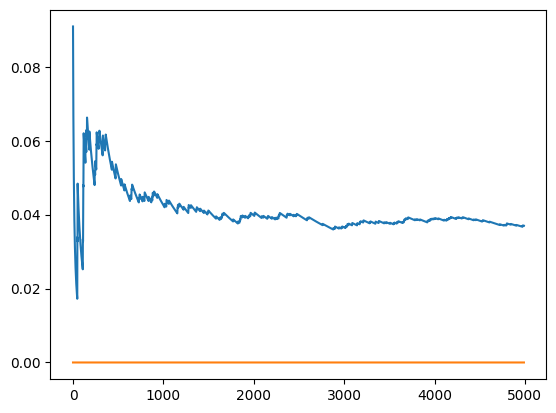

In [19]:
plt.plot(ret[2][10:])

In [25]:
ret = pure_exploration(env)

Episodes for: Pure exploration: 100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 56470.99it/s]


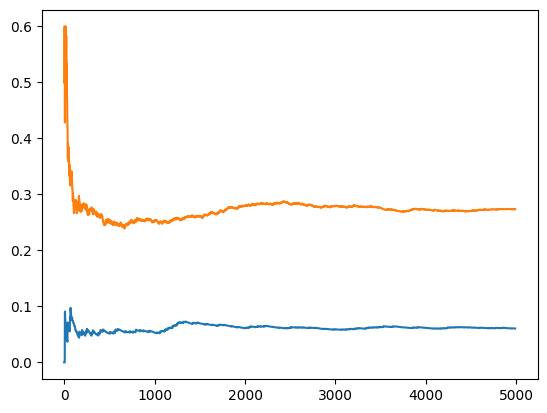

In [26]:
plt.plot(ret[2][10:])

In [27]:
ret[2]

array([[0.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.0606538 , 0.27368849],
       [0.0606538 , 0.27398374],
       [0.0606538 , 0.27387241]])

In [19]:
ret = softmax_exploration(env)

Episodes for: Softmax exploration: 100%|███████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 11673.21it/s]


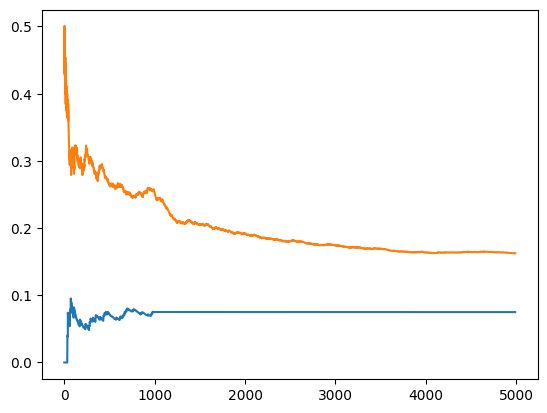

In [20]:
plt.plot(ret[2][10:])

In [5]:
ret = thompson_sampling(env)

Episodes for: Thompson sampling:   0%|                                                                                   | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_2014/3140580305.py:21: RuntimeWarning: divide by zero encountered in divide
  scale=alpha/(np.sqrt(N) + beta))
Episodes for: Thompson sampling: 100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 32447.78it/s]


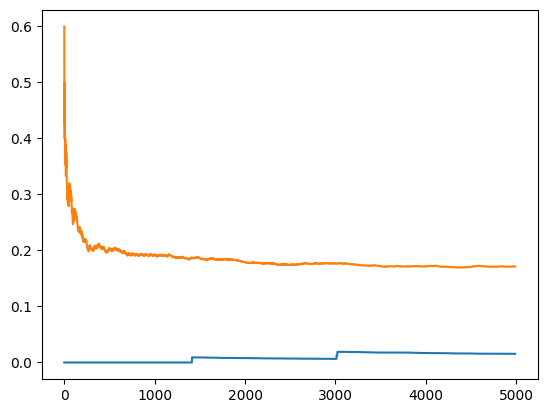

In [6]:
plt.plot(ret[2][10:])